In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

# Parameters

In [2]:
population = 500

In [3]:
travel_time = lambda q_x, t0_x, Q_x: t0_x * (1 + pow(q_x/Q_x, 2))

# Classes: Sections, Roads, Vehicles and the City

In [4]:
class Section:
    def __init__(self, name):
        self.name = name
        self.id = name[0]
        self.neighbors = list()

    def make_connection(self, section):
        self.neighbors.append(section)
        self.neighbors.sort(key=lambda x: x.id)

    def is_neighbor(self, section_id):
        for n in self.neighbors:
            if n.id == section_id:
                return True
        return False

In [5]:
class Road:
    def __init__(self, origin, destination, free_flow, capacity):

        self.origin = origin
        self.destination = destination
        self.id = self.origin.id + self.destination.id

        self.free_flow = free_flow
        self.capacity = capacity
        self.number_of_vehicles = 0
        self.randomness = -1 #np.random.rand()/50.0 # Random behavior of road (temporary increase of congestion)

    def reset(self):
        self.number_of_vehicles = 0

    def get_congestion(self):
        return self.travel_time(self.number_of_vehicles, self.free_flow, self.capacity, self.randomness)

    def travel_time(self, q_x, t0_x, Q_x, randomness):
        incident = randomness > np.random.rand()
        congestion = t0_x * (1 + pow(q_x/Q_x, 2)) * (5 if incident else 1)
        return congestion

    def add_car(self, influence):
        self.number_of_vehicles += influence

    def remove_car(self, influence):
        self.number_of_vehicles -= influence

In [6]:
class Vehicle: # RL Agent

    def __init__(self, vehicle_type, origin, destination, alpha=0.3, gamma=0.8, epsilon=1.0):

        self.vehicle_type = vehicle_type
        self.influence = 1 if (self.vehicle_type == "car") else 2
        self.id = int(np.random.rand() * 1000)

        self.origin = origin
        self.original_dest = destination
        self.destination = self.original_dest
        self.prev_location = None
        self.location = origin

        self.arrived = False
        self.randomness = -1 #np.random.rand()/20.0 # # Random behavior of drivers (destination change)

        self.q_table = {}

        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

    def initialize_q_value(self, state, action): # 1
        state_str = str(state)  # string as a key
        if state_str not in self.q_table:
            self.q_table[state_str] = {}
        if action not in self.q_table[state_str]:
            self.q_table[state_str][action] = 0.0 # -100.0 # Initialize Q-value to 0

    def reset(self):
        self.prev_location = None
        self.location = self.origin
        self.arrived = False
        self.destination = self.original_dest

    def pick_action(self, state):
        loc_id, dest_id, congestions = state

        possible_actions = list(congestions.keys())
        for a in possible_actions:
            self.initialize_q_value(state, a)

        if np.random.rand() < self.epsilon:
            return np.random.choice(possible_actions)
        else:
            best_value = float("-inf")
            best_action = None
            for action in possible_actions:
                value = self.q_table[str(state)][action]
                if value > best_value:
                    best_value = value
                    best_action = action
            return best_action

    def learn(self, state, action, reward, next_state):
        prev_loc, dest, prev_congestions = state
        new_loc, _, new_congestions = next_state

        next_possible_actions = list(new_congestions.keys())
        for a in next_possible_actions:
            self.initialize_q_value(next_state, a)

        best_future_q = max(self.q_table[str(next_state)].values())
        prev_q = self.q_table[str(state)][action]
        #new_q = ((1.0 - self.alpha) * prev_q) + (self.alpha * (reward + (self.gamma * best_future_q)))
        new_q =  prev_q + (self.alpha * (reward + (self.gamma * best_future_q)))
        self.q_table[str(state)][action] = new_q

    def move_to_section(self, section):

        #if section == self.location: return False

        self.prev_location = self.location
        self.location = section

        if self.location == self.destination: self.arrived = True

        if self.randomness > np.random.rand(): # Vehicle changed destination for some reason
            self.destination = np.random.choice((self.origin, np.random.choice(self.destination.neighbors)))

        return True

    def decay_epsilon(self, decay_rate, min_epsilon=0):
        self.epsilon = max(min_epsilon, self.epsilon * decay_rate)

In [7]:
class City: # RL Environment

    def __init__(self, sections, randomness):
        self.sections = sections
        self.roads = list()
        self.randomness = -1 # 0.05 # Random behavior of environment

    def reset(self):
        for r in self.roads: r.reset()

    def build_roads(self, roads):
        for road in roads:
            section1_id, section2_id, free_flow, capacity = road
            section1, section2 = self.get_section_from_id(section1_id), self.get_section_from_id(section2_id)
            if all((section1, section2)):
                section1.make_connection(section2)
                section2.make_connection(section1)
                self.roads.append(Road(section1, section2, free_flow, capacity))
                self.roads.append(Road(section2, section1, free_flow, capacity))

    def step(self, vehicle_influence, prev_loc, loc, dest, action):
        arrived = (loc.id == dest.id)

        action = action if not arrived else loc.id
        prev_loc_id = "x" if not prev_loc else prev_loc.id
        loc_id, to_section_id = loc.id, action

        moved = self.move_vehicle(vehicle_influence, prev_loc_id, loc_id, to_section_id)
        next_loc_id = to_section_id if moved else loc_id
        next_loc = self.get_section_from_id(next_loc_id)

        state = self.get_state(next_loc, dest)

        step_penalty = 0
        if self.get_road_from_o_d(loc_id, next_loc_id):
            step_penalty = -1 * self.get_road_from_o_d(loc_id, next_loc_id).get_congestion()
        elif (not arrived) and (not moved):
            step_penalty = -1 * self.get_road_from_o_d(prev_loc_id, loc_id).get_congestion()

        return step_penalty, state, next_loc


    def get_state(self, loc, dest):
        neighbors = loc.neighbors
        neighbor_congestions = {n.id: self.get_road_from_o_d(loc.id, n.id).number_of_vehicles for n in neighbors}
        state = [loc.id, dest.id, neighbor_congestions]
        return state

    def move_vehicle(self, vehicle_influence, prev_loc_id, loc_id, to_section_id):
        incident = self.randomness > np.random.rand()
        if not incident:
            old_road, new_road = self.get_road_from_o_d(prev_loc_id, loc_id), self.get_road_from_o_d(loc_id, to_section_id)
            if old_road: old_road.remove_car(vehicle_influence)
            if new_road: new_road.add_car(vehicle_influence)
            return True
        else: # Vehicle did not move for some reason (stochastic environment)
            return False

    def get_congestion(self):
        congestions = []
        for road in self.roads: congestions.append(road.get_congestion())
        return sum(congestions)

    def get_section_from_id(self, section_id):
        for s in self.sections:
            if s.id == section_id: return s
        return None

    def get_road_from_o_d(self, origin, destination):
        road_id = origin[0] + destination[0]
        for r in self.roads:
            if r.id == road_id: return r
        return None

# Constructing the city

In [8]:
def create_sampling_tables(sect_names, sect_sampling_coeff):

    sections, origin_sample_table, dest_sample_table = list(), list(), list()

    for idx, s in enumerate(sect_names):
        sections.append(Section(s))
        origin_sample_table.extend([sections[-1]]*sect_sampling_coeff[idx][0])
        dest_sample_table.extend([sections[-1]]*sect_sampling_coeff[idx][1])

    return sections, origin_sample_table, dest_sample_table

In [9]:
def generate_population(nr_vehicles, origin_sample_table, dest_sample_table):
    vehicles = list()
    for i in range(nr_vehicles):
        vehicle_type = "car" if np.random.rand() > 0.05 else "bus"
        origin, destination = np.random.choice(origin_sample_table), np.random.choice(dest_sample_table)
        while destination == origin: destination = np.random.choice(dest_sample_table)
        vehicles.append(Vehicle(vehicle_type, origin, destination))
    return vehicles

In [10]:
sect_names = ["AveHub","BusBay","CarCove","DashDale","EcoEnd","FastField","GearBay","HighHill","JamHub","KerbKey","LaneEnd"]
# How likely these sections should be origins and destinations?
sect_sampling_coeff = [(1, 9), (1, 9), (9, 1), (1, 1), (9, 1), (1, 1), (9, 1), (1, 1), (0, 10), (5, 5), (10, 0)]

# Road origins and destinations, free flow durations and capacities
roads = [["LaneEnd", "FastField", 2/60, 300], ["FastField", "HighHill", 8/60, 800], ["HighHill", "GearBay", 6/60, 500],\
         ["FastField", "JamHub", 13/60, 400], ["HighHill", "BusBay", 10/60, 500], ["GearBay", "BusBay", 15/60, 600], \
         ["GearBay", "CarCove", 25/60, 1000], ["AveHub", "JamHub", 3/60, 250], ["JamHub", "BusBay", 4/60, 250], \
         ["AveHub", "EcoEnd", 15/60, 600], ["AveHub", "KerbKey", 7/60, 300], ["JamHub", "DashDale", 9/60, 450], \
         ["EcoEnd", "KerbKey", 4/60, 250], ["DashDale", "CarCove", 3/60, 300]]
roads = [[r[0][0], r[1][0], r[2], r[3]] for r in roads]

In [11]:
sections, origin_sample_table, dest_sample_table = create_sampling_tables(sect_names, sect_sampling_coeff)
vehicles = generate_population(population, origin_sample_table, dest_sample_table)

city = City(sections, 0.05)
city.build_roads(roads)

In [12]:
print("--- Sections ---")
for s in city.sections:
    print(s.name, "neighbors to:", [x.name for x in s.neighbors])

print("\n--- Some of the vehicles ---")
for v in vehicles[:10]:
    print("%s is now at %s. It is going from %s to %s"%(v.vehicle_type, v.location.name, v.origin.name, v.destination.name))

--- Sections ---
AveHub neighbors to: ['EcoEnd', 'JamHub', 'KerbKey']
BusBay neighbors to: ['GearBay', 'HighHill', 'JamHub']
CarCove neighbors to: ['DashDale', 'GearBay']
DashDale neighbors to: ['CarCove', 'JamHub']
EcoEnd neighbors to: ['AveHub', 'KerbKey']
FastField neighbors to: ['HighHill', 'JamHub', 'LaneEnd']
GearBay neighbors to: ['BusBay', 'CarCove', 'HighHill']
HighHill neighbors to: ['BusBay', 'FastField', 'GearBay']
JamHub neighbors to: ['AveHub', 'BusBay', 'DashDale', 'FastField']
KerbKey neighbors to: ['AveHub', 'EcoEnd']
LaneEnd neighbors to: ['FastField']

--- Some of the vehicles ---
car is now at GearBay. It is going from GearBay to KerbKey
car is now at GearBay. It is going from GearBay to KerbKey
car is now at GearBay. It is going from GearBay to FastField
car is now at GearBay. It is going from GearBay to BusBay
car is now at CarCove. It is going from CarCove to AveHub
car is now at EcoEnd. It is going from EcoEnd to CarCove
bus is now at KerbKey. It is going from K

![image](https://i.imgur.com/faZJu3H.png)

In [13]:
origin_dest_counter = {x:[0, 0] for x in sect_names}
for v in vehicles:
    origin_dest_counter[v.origin.name][0] += 1
    origin_dest_counter[v.destination.name][1] += 1

max_dest, max_dest_nr, max_origin, max_origin_nr = None, 0, None, 0
for sect, values in origin_dest_counter.items():
    org, dest = values
    if org > max_origin_nr:
        max_origin_nr = org
        max_origin = sect
    if dest > max_dest_nr:
        max_dest_nr = dest
        max_dest = sect

print(max_origin, "is the most popular origin with", max_origin_nr, "vehicles.\n",\
      max_dest, "is the most popular destination with", max_dest_nr, "vehicles.")

CarCove is the most popular origin with 109 vehicles.
 JamHub is the most popular destination with 135 vehicles.


# Training

## Stats from random agents

Let's try out for one episode and see what a set of agents which make decisions at random can achieve in this environment.

Finished episode in 7870 steps.
Total reward: -33493.414



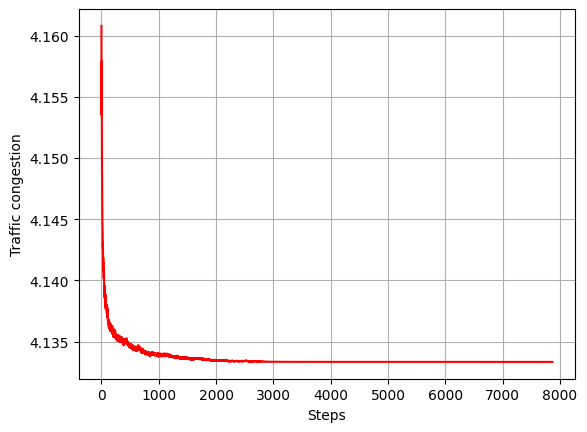

In [14]:
city.reset()
trajectories = dict()

for v in vehicles:
  v.reset()
  v.epsilon = 0.1
  trajectories[v.id] = [v.location.name]

episode_reward = 0
step_counter = 0
step_congestions = list()

while not all([v.arrived for v in vehicles]):

    step_counter += 1

    for v in vehicles:

        state = city.get_state(v.location, v.destination)
        action = v.pick_action(state)
        step_reward, next_state, next_loc = city.step(v.influence, v.prev_location, v.location, v.destination, action)
        v.move_to_section(next_loc)

        trajectories[v.id].append(next_loc.name)

        episode_reward += step_reward

    step_congestions.append(city.get_congestion())

print("Finished episode in %d steps." % (step_counter))
print("Total reward: %.3f\n" % (episode_reward))

plt.plot(step_congestions, color="red")
plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Traffic congestion")
plt.show()

In [15]:
for v in vehicles[:10]:
  print("%s #%d moving from %s to %s followed (first 10): " % (v.vehicle_type, v.id, v.origin.name, v.destination.name), trajectories[v.id][:10])

car #785 moving from GearBay to KerbKey followed (first 10):  ['GearBay', 'BusBay', 'GearBay', 'BusBay', 'GearBay', 'BusBay', 'GearBay', 'BusBay', 'GearBay', 'BusBay']
car #280 moving from GearBay to KerbKey followed (first 10):  ['GearBay', 'BusBay', 'GearBay', 'BusBay', 'GearBay', 'BusBay', 'GearBay', 'BusBay', 'GearBay', 'BusBay']
car #81 moving from GearBay to FastField followed (first 10):  ['EcoEnd', 'BusBay', 'AveHub', 'GearBay', 'EcoEnd', 'BusBay', 'AveHub', 'GearBay', 'EcoEnd', 'BusBay']
car #911 moving from GearBay to BusBay followed (first 10):  ['GearBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay', 'BusBay']
car #237 moving from CarCove to AveHub followed (first 10):  ['CarCove', 'DashDale', 'CarCove', 'DashDale', 'CarCove', 'DashDale', 'CarCove', 'DashDale', 'CarCove', 'DashDale']
car #140 moving from EcoEnd to CarCove followed (first 10):  ['AveHub', 'KerbKey', 'FastField', 'AveHub', 'EcoEnd', 'AveHub', 'HighHill', 'EcoEnd', 'AveHub', 

## Training Loop

In [16]:
episode_rewards = list()
episode_steps = list()
num_episodes = 10000#0
decay_rate = 0.99#99

start_time = time.time()

for episode in range(num_episodes):

    city.reset()
    for v in vehicles: v.reset()

    episode_reward = 0
    step_counter = 0

    while not all([v.arrived for v in vehicles]):

        step_counter += 1

        for v in vehicles:

            state = city.get_state(v.location, v.destination)
            action = v.pick_action(state)
            step_reward, next_state, next_loc = city.step(v.influence, v.prev_location, v.location, v.destination, action)
            v.learn(state, action, step_reward, next_state)
            v.move_to_section(next_loc)

            episode_reward += step_reward

    print("\rAt episode: %d" % (episode+1), end='')
    episode_steps.append(step_counter)
    episode_rewards.append(episode_reward)

    for v in vehicles: v.decay_epsilon(decay_rate)

    if ((episode+1) % (num_episodes//50) == 0) or (episode == 0):
        print("\r------------ EPISODE #%d ------------\n [FINAL REWARD] %.3f [EPSILON] %.6f [STEPS] %d" \
              % (episode+1, episode_reward, v.epsilon, step_counter))


print("\n\n[COMPLETED] : %s" % (time.strftime("%H hours, %M minutes, %S seconds", time.gmtime(time.time() - start_time))))


------------ EPISODE #1 ------------
 [FINAL REWARD] -6775.306 [EPSILON] 0.099000 [STEPS] 322
------------ EPISODE #200 ------------
 [FINAL REWARD] -1713.937 [EPSILON] 0.013398 [STEPS] 112
------------ EPISODE #400 ------------
 [FINAL REWARD] -1194.598 [EPSILON] 0.001795 [STEPS] 98
------------ EPISODE #600 ------------
 [FINAL REWARD] -1187.617 [EPSILON] 0.000241 [STEPS] 90
At episode: 695

KeyboardInterrupt: ignored

In [ ]:
#a = {item: value for item, value in v.q_table.items() if item[:9] == "['B', 'B'"}
#print(a)
#v.q_table.items()

In [ ]:
plt.plot(episode_rewards, color="purple")
plt.xlabel("Episode")
plt.ylabel("Episode rewards")
plt.grid(True)
plt.show()

In [ ]:
plt.plot(episode_steps, color="purple")
plt.xlabel("Episode")
plt.ylabel("Episode steps")
plt.grid(True)
plt.show()

# Testing the agents

In [ ]:
city.reset()
trajectories = dict()

for v in vehicles:
  v.reset()
  v.epsilon = 0.1
  trajectories[v.id] = [v.location.name]

episode_reward = 0
step_counter = 0
step_congestions = list()

while not all([v.arrived for v in vehicles]):

    step_counter += 1

    for v in vehicles:

        state = city.get_state(v.location, v.destination)
        action = v.pick_action(state)
        step_reward, next_state, next_loc = city.step(v.influence, v.prev_location, v.location, v.destination, action)
        v.move_to_section(next_loc)

        trajectories[v.id].append(next_loc.name)

        episode_reward += step_reward
    print("\rStep: %d" % (step_counter), end='')
    step_congestions.append(city.get_congestion())

print("\nFinished episode in %d steps." % (step_counter))
print("Total reward: %.3f\n\n" % (episode_reward))

plt.plot(step_congestions, color="red")
plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Traffic congestion")
plt.show()

In [ ]:
for v in vehicles[:10]:
  print("%s #%d moving from %s to %s followed (first 10): " % (v.vehicle_type, v.id, v.origin.name, v.destination.name), trajectories[v.id][:10])